### DigiMat Pro: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  \partial_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

In [1]:
#@title
# Setup system environment and define utility functions and variables

print("Installing libraries, takes 2-3 minutes.")

from google.colab import files

!wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" >> ilog1 2>> ilog2 && bash "/tmp/fenics-install.sh" >> ilog1 2>> ilog2

!apt-get install imagemagick-6-common
!apt-get install imagemagick-6.q16hdri
!apt-get install ffmpeg

!touch githeadid.txt
!rm -f mesh.xdmf
!rm -f mesh.h5
!rm -f plot_u_3D_02.py
!wget -c http://www.csc.kth.se/~jjan/digitalmath/cube/mesh.xdmf
!wget -c http://www.csc.kth.se/~jjan/digitalmath/cube/mesh.h5
!wget -c http://www.csc.kth.se/~jjan/digitalmath/plot_u_3D_02.py
!wget -c http://www.csc.kth.se/~jjan/digitalmath/cube01.py
!wget -c -O ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz 'https://www.paraview.org/paraview-downloads/download.php?submit=Download&version=v5.9&type=binary&os=Linux&downloadFile=ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz'
!tar xzvf ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz --skip-old-files 1>plog1 2>plog2


#!wget -c http://www.csc.kth.se/~jjan/digitalmath/ruc/ParaView-UserSettings.json >> ilog1 2>> ilog2
#!mkdir ~/.config/ParaView
#!cp ParaView-UserSettings.json ~/.config/ParaView/ >> ilog1 2>> ilog2



Installing libraries, takes 2-3 minutes.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda

In [2]:
%%writefile file.py

# Copyright (c) 2017-2018 Johan Jansson, Mans Andersson, Cem Degirmenci, David Kamensky, FEniCS community contributions 
from dolfin import *
from ufl import replace

import time
import sys
import os

tottime1 = time.perf_counter()

#import logging
#logging.captureWarnings(True)

set_log_level(40);

if(MPI.comm_world.rank != 0):
  sys.stdout = open(os.devnull, 'w')

with open("githeadid.txt","r") as f:
    githeadid = f.read()

print("githeadid:", githeadid)


Dfile = open("D.txt", "w+")
Lfile = open("L.txt", "w+")


# Set option to allow extrapolation
parameters["allow_extrapolation"] = True

XMIN = -10.; XMAX = 10; YMIN = 1e-5; YMAX = 10.; ZMIN = -10.; ZMAX = 10.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=30 # Geometry and mesh

mesh = Mesh()
with XDMFFile("mesh.xdmf") as infile:
        infile.read(mesh)

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1);
ZE = FiniteElement("DG", mesh.ufl_cell(), 0);
h = CellDiameter(mesh); # FEM functions
V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE); Z = FunctionSpace(mesh, ZE); 
v = TestFunction(V); q = TestFunction(Q);
utr = TrialFunction(V); ptr = TrialFunction(Q)
u = Function(V); u0 = Function(V); u00 = Function(V); p = Function(Q); p0 = Function(Q); p00 = Function(Q);
up = Function(V); pp = Function(Q);
udiff = Function(V); pdiff = Function(Q);

psi_m = Expression(("0.", "0.", "0."), element = V.ufl_element()) # momentum data
psi_c = Expression("0.", element = Q.ufl_element()) # continuity data
bpsi_m = Expression(("0.", "0.", "0."), element = V.ufl_element()) # boundary momentum data

uzero = Expression(("0.", "0.", "0."), element = V.ufl_element()) # Inflow velocity
uin = Expression(("1.", "0.", "0."), element = V.ufl_element()) # Inflow velocity
uindual = Expression(("1.", "0.", "1."), element = V.ufl_element()) # Inflow velocity
im = Expression("sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) >= 5 ? 1. : 0.", eps=eps, element = Q.ufl_element())
nm = Expression("sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) < 5 ? 1. : 0.", eps=eps, element = Q.ufl_element())
 
class InflowBoundary(SubDomain):                                                                         
    def inside(self, x, on_boundary):                                                                     
        return (sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) >= 5.)

class DualInflowBoundary1(SubDomain):                                                                         
    def inside(self, x, on_boundary):
        return sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) >= 5.

class DualInflowBoundary2(SubDomain):                                                                         
    def inside(self, x, on_boundary):
        return on_boundary and ((sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) < 5.))

stepcounter = 0; 
 
import time
 
 
class RUCProblem(NonlinearProblem):
    def __init__(self, J, F, bcs):
        self.bilinear_form = J
        self.linear_form = F
        self.bcs = bcs
        NonlinearProblem.__init__(self)
 
    def F(self, b, x):
        ta1 = time.perf_counter();
        assemble(self.linear_form, tensor=b)
        ta2 = time.perf_counter();
        #print("RUC assemble vector timer:" + str(ta2 - ta1));
        for bc in self.bcs:
            bc.apply(b, x)
 
    def J(self, A, x):
        ta1 = time.perf_counter();
        assemble(self.bilinear_form, tensor=A)
        ta2 = time.perf_counter();
        #print("RUC assemble matrix timer:" + str(ta2 - ta1));
        for bc in self.bcs:
            bc.apply(A)


class RUCSolver(NewtonSolver):
    def __init__(self):
        NewtonSolver.__init__(self, MPI.comm_world,
                              PETScKrylovSolver(), PETScFactory.instance())

    def solver_setup(self, A, P, problem, iteration):
        self.linear_solver().set_operator(A)

        #PETScOptions.set("ksp_type", "gmres")
        PETScOptions.set("ksp_type", "tfqmr")
        #PETScOptions.set("ksp_monitor")
        #PETScOptions.set("pc_type", "hypre")
        #PETScOptions.set("pc_type", "sor")
        PETScOptions.set("pc_type", "pbjacobi")
        #PETScOptions.set("pc_hypre_type", "sor")

        PETScOptions.set("ksp_rtol", "1e-2")
        PETScOptions.set("ksp_atol", "1e-2")

        self.linear_solver().parameters["nonzero_initial_guess"] = True
        self.linear_solver().set_from_options()

    def converged(self, r, problem, iteration):
        return (iteration > 0)

xdmf_file_ei = XDMFFile("ei.xdmf")
xdmf_file_ei.parameters["flush_output"] = True
xdmf_file_ei.parameters["functions_share_mesh"] = True
xdmf_file_ei.parameters["rewrite_function_mesh"] = False

u_out = Function(V)
xdmf_file_u = XDMFFile("u.xdmf")
xdmf_file_u.parameters["flush_output"] = True
xdmf_file_u.parameters["functions_share_mesh"] = True
xdmf_file_u.parameters["rewrite_function_mesh"] = False

p_out = Function(Q)
xdmf_file_p = XDMFFile("p.xdmf")
xdmf_file_p.parameters["flush_output"] = True
xdmf_file_p.parameters["functions_share_mesh"] = True
xdmf_file_p.parameters["rewrite_function_mesh"] = False

xdmf_file_ud = XDMFFile("ud.xdmf")
xdmf_file_ud.parameters["flush_output"] = True
xdmf_file_ud.parameters["functions_share_mesh"] = True
xdmf_file_ud.parameters["rewrite_function_mesh"] = False

xdmf_file_pd = XDMFFile("pd.xdmf")
xdmf_file_pd.parameters["flush_output"] = True
xdmf_file_pd.parameters["functions_share_mesh"] = True
xdmf_file_pd.parameters["rewrite_function_mesh"] = False

nn = FacetNormal(mesh);
n = Function(V);

# Weak normal projection
rwn = dot(n, v)*dx + 1e2/(1*h)*dot(n-nn, v)*ds
J = derivative(rwn, n)
bcs = []
rucproblem = RUCProblem(J, rwn, bcs)
rucsolver = RUCSolver()
rucsolver.parameters["relative_tolerance"] = 1e-6;
#rucsolver.parameters["maximum_iterations"] = 1;
ts1 = time.perf_counter();
rucsolver.solve(rucproblem, n.vector())
ts2 = time.perf_counter();
#print("Normal projection solve timer:" + str(ts2 - ts1));

xdmf_file_n = XDMFFile("n.xdmf")
xdmf_file_n.parameters["flush_output"] = True
xdmf_file_n.parameters["functions_share_mesh"] = True
xdmf_file_n.parameters["rewrite_function_mesh"] = False

n.rename("n", "")
xdmf_file_n.write(n, 0.0)

udiffnorm = 0.0
unorm = 1.0

pdiffnorm = 0.0
p0diffnorm = 0.0
pnorm = 1.0
udiffrel = 0
pdiffrel = 0

ap0 = inner(utr, v)*dx
Lp0 = inner(uin, v)*dx
Ap0, bp0 = assemble_system(ap0, Lp0, [])
mysolver = KrylovSolver('gmres','petsc_amg')
mysolver.solve(Ap0, u0.vector(), bp0)

u.vector()[:] = u0.vector()

import os.path


hmin = MPI.min(MPI.comm_world, mesh.hmin());
print("vertices:", mesh.num_vertices());
print("hmin:", hmin);
k = 10*hmin; nu = 1e-12; c1 = 1; c2 = 1 # Timestep, viscosity and stabilization parameters
t, T = 0., 10.0; gamma = 1e2*1./(1*h); wgamma = 0.1/(1*h) # Time interval and penalty parameter

kf = Constant(k)

rdtol = 1e-2


chkp_mode = False
if os.path.isfile('u_chkp2.xdmf') and os.path.isfile('p_chkp2.xdmf'):
    chkp_mode = True

if chkp_mode:
    
    u_in = Function(V)
    with XDMFFile(mesh.mpi_comm(), "u_chkp2.xdmf") as file:
        file.read_checkpoint(u_in, "u_out", 0)

        ap0 = inner(utr, v)*dx
        Lp0 = inner(u_in, v)*dx
        Ap0, bp0 = assemble_system(ap0, Lp0, [])
        mysolver = KrylovSolver('gmres','petsc_amg')
        mysolver.solve(Ap0, u0.vector(), bp0)

        #w.vector().copy(w0.vector())
        u.vector()[:] = u0.vector()
        u00.vector()[:] = u0.vector()

    p_in = Function(Q)
    with XDMFFile(mesh.mpi_comm(), "p_chkp2.xdmf") as file:
        file.read_checkpoint(p_in, "p_out", 0)

        p.vector()[:] = p_in.vector()
        p0.vector()[:] = p_in.vector()
        p00.vector()[:] = p_in.vector()

        print("Chkp:", "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "rank:", MPI.comm_world.rank);


    with XDMFFile(mesh.mpi_comm(), "u_chkp2.xdmf") as file:
        file.write_checkpoint(u_in, "u_out", 0, XDMFFile.Encoding.HDF5, append=False)

    with XDMFFile(mesh.mpi_comm(), "p_chkp2.xdmf") as file:
        file.write_checkpoint(p_in, "p_out", 0, XDMFFile.Encoding.HDF5, append=False)

stabcounter = 0
c2 = 1.

c1f = Constant(c1)
c2f = Constant(c2)
nuf = Constant(nu)
maxit = 9
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop

    if stepcounter < 2 and not chkp_mode:
        #print("mode: startup")
        k = 5*hmin;
        c1 = 4;
        c2 = 4.
        maxit = 3
        nu = 1e-12;
        #rdtol = 1e-2
    else:
        #print("mode: ramp-real","stabcounter: ",stabcounter)
        if stepcounter < 10:
            maxit = 4
        else:
            maxit = 9
        pdiff.vector()[:] = p0.vector()
        pdiff.vector().axpy(-1, p00.vector())
        p0diffnorm = pdiff.vector().norm('l2');
        pnorm = p0.vector().norm('l2');
        #print("udiffrel:",udiffrel)
        #print("pdiffrel:",pdiffrel)
        if(pnorm > 1e-8):
            if stabcounter == 0 and ((udiffrel + pdiffrel) < 0.5):
                #print("ramping")
                k = min(10*hmin, 1.3*k);
                c1 = max(1, 0.7*c1)
                c2 = max(1, 0.7*c2)
                if c2 < 1e-2:
                    c2 = 1e-12
                nu = max(0., 0.7*nu)
                if nu < 1e-4:
                    nu = 1e-12
                
        nu = 1e-12;
        #rdtol = 1e-2

    c1f.assign(c1)
    c2f.assign(c2)
    d = 1*c1f*hmin
    dp = 1*c1f*hmin

    t1 = time.perf_counter();
    for i in range(0, maxit):
        kf.assign(k)
        nuf.assign(nu)
        um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
        R = ((u - u0)/kf + grad(p) + grad(um)*um)
        C_av = ((abs(R[0]) + abs(R[1]) + abs(R[2]) + abs(div(um))))
        d32 = 0.04*C_av*h**3.
        #d32 = 1e-8*hmin

        ti1 = time.perf_counter();

        #gamma*(im*inner(u - uin, v))*dx + im*1e-2*inner(grad(um), grad(v))*dx + # Weak boundary conditions

        rs_m = ((nuf + c2f*d32)*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v))*dx
        rs_c = (inner(div(u), q))*dx

        LS_u = d*(inner(grad(p) + grad(um)*um, grad(v)*um) + inner(div(um), div(v)))*dx
        LS_p = dp*(inner(grad(p) + grad(um)*um, grad(q)))*dx

        rmp_m = replace(rs_m, { u: um })
        rmp_c = replace(rs_c, { u: um })

        r_m = (inner(u - u0, v)/kf)*dx + rmp_m + wgamma*nm*inner(u, n)*inner(v, n)*ds + LS_u
        r_c = (2*kf*inner(grad(p - p0), grad(q)))*dx + rmp_c + .5*hmin*hmin*p*q*dx + \
              LS_p
        # (c2f*d32)*inner(grad(p), grad(q))*dx + 
        # Solve momentum
        ib = InflowBoundary()
        dbc = DirichletBC(V, uin, ib);
        bcs = [dbc]

        J = derivative(r_m, u)

        rucproblem = RUCProblem(J, r_m, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.perf_counter();
        rucsolver.solve(rucproblem, u.vector())
        #solve(r_m == 0, u);
        ts2 = time.perf_counter();

        udiff.vector()[:] = u.vector()
        udiff.vector().axpy(-1, u00.vector())
        udiffnorm = udiff.vector().norm('l2');
        unorm = u.vector().norm('l2');
        uinfnorm = u.vector().norm('linf');
        u00norm = u00.vector().norm('l2');
        u00infnorm = u00.vector().norm('linf');
        udiffinfnorm = udiff.vector().norm('linf');
        u00.vector()[:] = u.vector()

        J = derivative(r_c, p)
        bcs = []
        
        rucproblem = RUCProblem(J, r_c, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.perf_counter();
        rucsolver.solve(rucproblem, p.vector())
        #solve(r_c == 0, p);
        ts2 = time.perf_counter();
        
        pdiff.vector()[:] = p.vector()
        pdiff.vector().axpy(-1, p0.vector())
        pdiffnorm = pdiff.vector().norm('l2');
        pnorm = p.vector().norm('l2');
        pinfnorm = p.vector().norm('linf');
        p0norm = p0.vector().norm('l2');
        p0infnorm = p0.vector().norm('linf');
        pdiffinfnorm = pdiff.vector().norm('linf');
        p0.vector()[:] = p.vector()
        

        udiffrel = 0
        udiffinfrel = 0
        if(u00norm > 1e-8 and u00infnorm > 1e-8):
            udiffrel = udiffnorm/u00norm
            udiffinfrel = uinfnorm/u00infnorm
        pdiffrel = 0
        pdiffinfrel = 0
        if(p0norm > 1e-8 and p0infnorm > 1e-8):
            pdiffrel = pdiffnorm/p0norm
            pdiffinfrel = pinfnorm/p0infnorm

        ti2 = time.perf_counter();
        print("Iter", "i:", i, "k:", round(k, 5), "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "ud:", round(udiffrel, 5), "pd:", round(pdiffrel, 5), "udinf:", round(udiffinfrel, 5), "pdinf:", round(pdiffinfrel, 5), "c1:", round(c1, 5), "c2:", round(c2, 5), "itimer:", round((ti2 - ti1), 5), "rank:", MPI.comm_world.rank);
        sys.stdout.flush()

        if (udiffrel < rdtol and pdiffrel < rdtol):
            break;
        elif stepcounter > 20 and ((i == maxit - 1) or max(udiffinfrel, pdiffinfrel) > 1.1):
            stabcounter = 5
            c2 = min(10., c2*1.3)
            k = max(5*hmin, k/1.3);
            u.vector()[:] = u0.vector()
            p.vector()[:] = p00.vector()
            i = 0
            break;
            
                
    # Output
    if stepcounter % 1 == 0:
      ap0 = inner(utr, v)*dx
      Lp0 = inner(u, v)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','petsc_amg')
      mysolver.solve(Ap0, u_out.vector(), bp0)

      u_out.rename("u", "")
      xdmf_file_u.write(u_out, t)

      ap0 = inner(ptr, q)*dx
      Lp0 = inner(p, q)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','petsc_amg')
      mysolver.solve(Ap0, p_out.vector(), bp0)

      p_out.rename("p", "")
      xdmf_file_p.write(p_out, t)

      with XDMFFile(mesh.mpi_comm(), "u_chkp.xdmf") as file:
            file.write_checkpoint(u_out, "u_out", 0, XDMFFile.Encoding.HDF5, append=False)

      with XDMFFile(mesh.mpi_comm(), "p_chkp.xdmf") as file:
            file.write_checkpoint(p_out, "p_out", 0, XDMFFile.Encoding.HDF5, append=False)
            
    t += k; stepcounter += 1; #u0 = interpolate(u, V); # Shift to next timestep
    if stabcounter > 0:
        stabcounter -= 1
    u0.vector()[:] = u.vector()
    p00.vector()[:] = p.vector()

    t2 = time.perf_counter();
    ML = nm*p*nn[2]*ds
    MD = nm*p*nn[0]*ds

    FL = assemble(ML)
    FD = assemble(MD)
    
    Dfile.write(str(FD) + "\n"); Dfile.flush();
    Lfile.write(str(FL) + "\n"); Lfile.flush();

    print("Step", "t:", round(t, 5), "stepc:", stepcounter, "iters:", i, "k:", round(k, 5), "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "L:", round(FL, 5), "D:", round(FD, 5), "c1:", round(c1, 5), "stept:", round((t2 - t1), 5), "rank:", MPI.comm_world.rank);
    sys.stdout.flush()


up.vector()[:] = u.vector()
pp.vector()[:] = p.vector()

u.vector().zero()
u0.vector().zero()
u00.vector().zero()
p.vector().zero()
p0.vector().zero()
p00.vector().zero()

u.vector()[:] = 1e-4

print("Solving dual")

dnu = Expression("sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) >= 10 ? (sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2]) - 10.) : 0.", eps=eps, element = Q.ufl_element())

c1 = 1.
c2 = 1.
C_av = 0.01*((abs(u[0]) + abs(u[1]) + abs(u[2])))
d32 = 0.1*c2*C_av*h**(3./2.)

k = 20.*hmin;
c1 = 1;
c2 = 1;

t, T = 0., 10.0
stepcounter = 0
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop

    for i in range(0, 3):

        c1f.assign(c1)
        c2f.assign(c2)
        kf.assign(k)

        d = c1f*hmin
        dp = c1f*hmin
                
        um = theta*u + (1.0-theta)*u0

        rs_m = (nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v))*dx
        rs_c = (inner(div(u), q))*dx

        rsp_m = replace(rs_m, { u: up, p: pp })
        rsp_c = replace(rs_c, { u: up, p: pp }) + hmin*hmin*hmin*h*pp*q*dx

        rds_m = adjoint(derivative(rsp_m, up, utr), (v, utr))
        rds_m = action(rds_m, u)
        rds_c = adjoint(derivative(rsp_c, pp, ptr), (q, ptr))
        rds_c = action(rds_c, p)

        # Adjoint cross-component terms
        rdsx_m = derivative(action(rds_c, p), up, v)
        rdsx_c = derivative(action(rds_m, u), pp, q)

        Ld_m = inner(psi_m, v)*dx + inner(bpsi_m, v)*ds
        Ld_c = inner(psi_c, q)*dx

        rlds_m = rds_m + rdsx_m #- Ld_m
        rlds_c = rds_c + rdsx_c #- Ld_c

        rldmp_m = replace(rlds_m, { u: um })
        rldmp_c = replace(rlds_c, { u: um })

        LS_u = d*(inner(grad(p) + grad(um)*um, grad(v)*um) + inner(div(um), div(v)))*dx
        LS_p = dp*(inner(grad(p) + grad(um)*um, grad(q)))*dx

        rd_m = (inner(u - u0, v)/kf)*dx + rldmp_m + LS_u + d32*inner(grad(um), grad(v))*dx
        rd_c = (2*kf*inner(grad(p - p0), grad(q)))*dx + rldmp_c + LS_p + 1*hmin*hmin*p*q*dx + 1*h*h*inner(grad(p), grad(q))*dx + d32*inner(grad(p), grad(q))*dx

        # Solve momentum
        ib1 = DualInflowBoundary1()
        dbc1 = DirichletBC(V, uzero, ib1);
        ib2 = DualInflowBoundary2()
        dbc2 = DirichletBC(V, uindual, ib2);
        bcs = [dbc1, dbc2]

        J = derivative(rd_m, u)

        rucproblem = RUCProblem(J, rd_m, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.perf_counter();
        rucsolver.solve(rucproblem, u.vector())
        #solve(r_m == 0, u)
        ts2 = time.perf_counter();

        udiff.vector()[:] = u.vector()
        udiff.vector().axpy(-1, u00.vector())
        udiffnorm = udiff.vector().norm('l2');
        unorm = u.vector().norm('l2');
        uinfnorm = u.vector().norm('linf');
        u00norm = u00.vector().norm('l2');
        u00infnorm = u00.vector().norm('linf');
        udiffinfnorm = udiff.vector().norm('linf');
        u00.vector()[:] = u.vector()


        J = derivative(rd_c, p)
        bcs = []

        rucproblem = RUCProblem(J, rd_c, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.perf_counter();
        rucsolver.solve(rucproblem, p.vector())
        #solve(r_c == 0, p)
        ts2 = time.perf_counter();

        pdiff.vector()[:] = p.vector()
        pdiff.vector().axpy(-1, p0.vector())
        pdiffnorm = pdiff.vector().norm('l2');
        pnorm = p.vector().norm('l2');
        pinfnorm = p.vector().norm('linf');
        p0norm = p0.vector().norm('l2');
        p0infnorm = p0.vector().norm('linf');
        pdiffinfnorm = pdiff.vector().norm('linf');
        p0.vector()[:] = p.vector()

        udiffrel = 0
        udiffinfrel = 0
        if(u00norm > 1e-8 and u00infnorm > 1e-8):
            udiffrel = udiffnorm/u00norm
            udiffinfrel = uinfnorm/u00infnorm
        pdiffrel = 0
        pdiffinfrel = 0
        if(p0norm > 1e-8 and p0infnorm > 1e-8):
            pdiffrel = pdiffnorm/p0norm
            pdiffinfrel = pinfnorm/p0infnorm

        if (udiffrel < rdtol and pdiffrel < rdtol):
            break;

    # Output
    if stepcounter % 4 == 0 or abs(T - t) <= k:
      ap0 = inner(utr, v)*dx
      Lp0 = inner(u, v)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','petsc_amg')
      mysolver.solve(Ap0, u_out.vector(), bp0)

      u_out.rename("ud", "")
      xdmf_file_ud.write(u_out, t)

      ap0 = inner(ptr, q)*dx
      Lp0 = inner(p, q)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','petsc_amg')
      mysolver.solve(Ap0, p_out.vector(), bp0)

      p_out.rename("pd", "")
      xdmf_file_pd.write(p_out, t)


    t += k; stepcounter += 1; # Shift to next timestep
    u0.vector()[:] = u.vector()
    p00.vector()[:] = p.vector()

    print("Step dual", "t:", round(t, 5), "stepc:", stepcounter, "iters:", i, "k:", round(k, 5), "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "L:", round(FL, 5), "D:", round(FD, 5), "c1:", round(c1, 5), "stept:", round((t2 - t1), 5), "rank:", MPI.comm_world.rank);

    
rs_m = (nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v))*dx
rs_c = (inner(div(u), q))*dx

rsp_m = replace(rs_m, { u: up, p: pp })
rsp_c = replace(rs_c, { u: up, p: pp })

z = TestFunction(Z)
Lei = replace(rsp_m, {v:u*z}); # Construct error indicators
ei = assemble(Lei)

eif = Function(Z)
eif.vector()[:] = ei

eif.rename("ei", "")
xdmf_file_ei.write(eif)

gamma = abs(ei.get_local()) # Get value array (assume serial implementation)
cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())

adapt_ratio = 0.002

gamma_0 = sorted(gamma, reverse=True)[int(len(gamma)*adapt_ratio) - 1]
gamma_0 = MPI.max(MPI.comm_world, gamma_0);
for c in cells(mesh):
    cell_markers[c] = gamma[c.index()] > gamma_0
mesh = refine(mesh, cell_markers)

xdmf_file_rmesh = XDMFFile("mesh.xdmf")
xdmf_file_rmesh.parameters["flush_output"] = True
xdmf_file_rmesh.parameters["functions_share_mesh"] = True
xdmf_file_rmesh.parameters["rewrite_function_mesh"] = False
xdmf_file_rmesh.write(mesh)

tottime2 = time.perf_counter()

print("Total solve time:",round(tottime2 - tottime1, 5))


Writing file.py


In [3]:
for i in range(0, 6):
  print("Adaptive iteration:", i)
  !mpirun --allow-run-as-root -np 20 python3 -u file.py
#!mpirun --allow-run-as-root -np 4 python3 -u file.py
#!mpirun --allow-run-as-root -np 4 python3 -u file.py
#!mpirun --allow-run-as-root -np 4 python3 -u file.py
#!mpirun --allow-run-as-root -np 4 python3 -u file.py


Adaptive iteration: 0
githeadid: 
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
vertices: 224
hmin: 0.33145630368119416
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Ca

In [4]:
!pwd
!rm *.png
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython cube01.py
!ffmpeg -y -r 16 -f image2 -s 1280x720 -i "test%03d.png" -vcodec libx264 -crf 25  -pix_fmt yuv420p foo.mp4 1>mlog1 2>mlog2
!cp foo.mp4 /usr/local/share/jupyter/nbextensions/
!ffmpeg -y -i foo.mp4 -filter_complex "fps=16,setsar=1,palettegen" -t 3 palette.png
!ffmpeg -y -i foo.mp4 -i palette.png -filter_complex "[0]fps=16,setsar=1[x];[x][1:v]paletteuse" -t 3 foo.gif



/content
rm: cannot remove '*.png': No such file or directory
[0.0, 1.657281518405971, 3.314563036811942, 4.971844555217912, 6.629126073623883, 8.286407592029853, 9.943689110435823]
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable


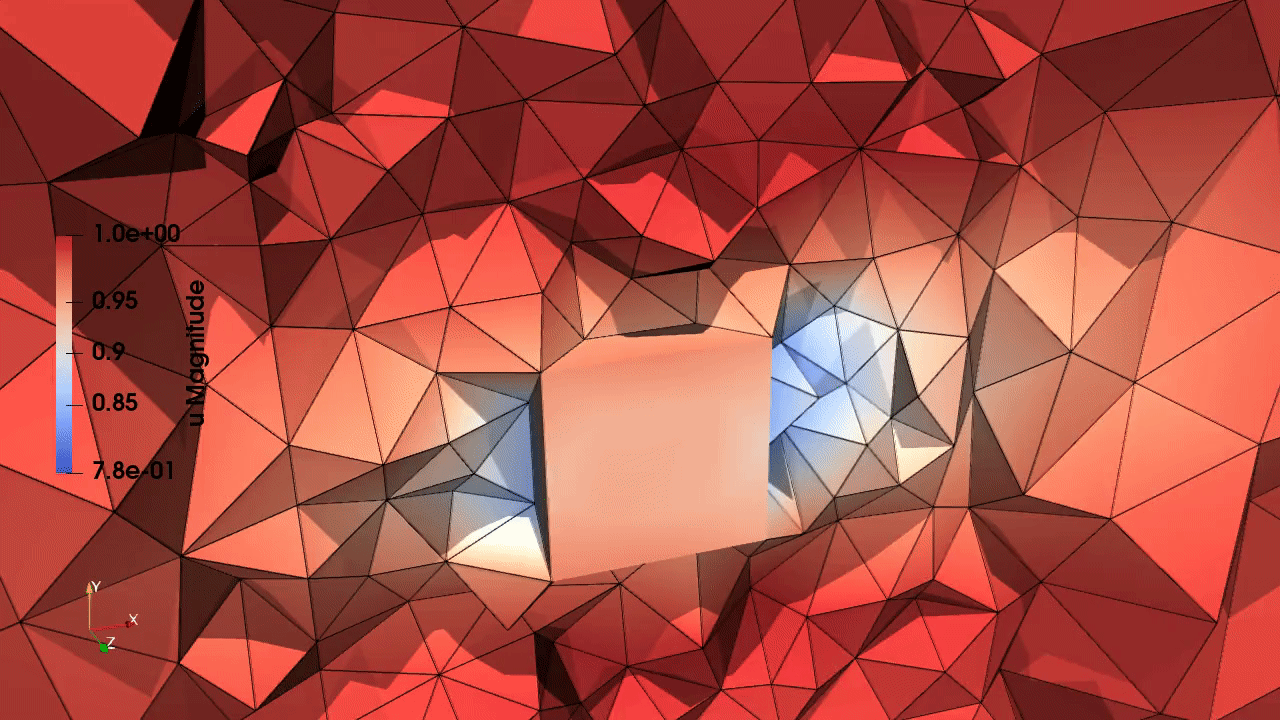

In [5]:
#@title


from IPython.display import HTML
from base64 import b64encode


import os
import time
import subprocess
from IPython.display import clear_output
#from IPython.core.display import display, HTML
import glob
import shutil
import os.path

def show_image(path_to_image, width=None, height=None):

    mime_type = None
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    display(HTML("<img src='%s' %s%s>" % (data_url, width_str, height_str)))

clear_output(wait=True)
display(HTML('<h1>Simulation output</h1>'))
#batcmd='grep Step log1|tail -n 1'
#result = subprocess.check_output(batcmd, shell=True, cwd="/content/", text=True)
#display(HTML('<tt style="font-size: 10px;">%s</tt>' % result))

show_image('foo.gif', width=512)

